In [5]:
# load modules
import os, sys, math, cv2, keras
import numpy as np
from PIL import Image
from natsort import natsorted
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from model_structure import *

ModuleNotFoundError: No module named 'model_structure'

In [5]:
import matplotlib
print(np.__version__)
print(matplotlib.__version__)

1.19.5
3.3.3


In [1]:
!python --version

Python 3.8.2


In [2]:
# dataset location
TEETH_DATASET, TEETH_PBL, TEETH_NUMBER = './teeth-dataset', './teeth-pbl', './teeth-number'

In [3]:
# loading dataset function
def load_dataset(dataset_folder, rgb = False, normalize = True):
    images = []
    for teeth in natsorted(os.listdir(dataset_folder)):
        image = Image.open(os.path.join(dataset_folder, teeth))
        image = resize_image(image, (2752, 1372))
        width, height = image.size
        image = image.crop((300, 300, width-300, height))
        image = resize_image(image, (512, 512))
        image = np.asarray(image) if rgb else to_one_channel(np.asarray(image))
        images.append(image)
    if not rgb:
        images = np.asarray(images) / 255.0 if normalize else np.asarray(images)
        images = np.reshape(images, (len(images),images.shape[1], images.shape[2], 1))
    return images

# convert image to grayscale
def to_one_channel(image):
    return image[:,:,0] if len(image.shape)>2 else image

# resize the image
def resize_image(image, new_shape):
    image = image.resize((new_shape),Image.ANTIALIAS)
    return image

# split dataset into train and test
def split_train_test(tooth, masks, train_percentage):
    divide_index = math.ceil(len(tooth)*train_percentage/100)
    X_train=tooth[:divide_index,:,:,:]
    X_test=tooth[divide_index:,:,:,:]
    y_train=masks[:divide_index,:,:,:]
    y_test=masks[divide_index:,:,:,:]
    return (X_train, y_train),(X_test, y_test)

In [4]:
# load dataset
original_dataset = load_dataset(TEETH_DATASET)
pbl_dataset = load_dataset(TEETH_PBL)

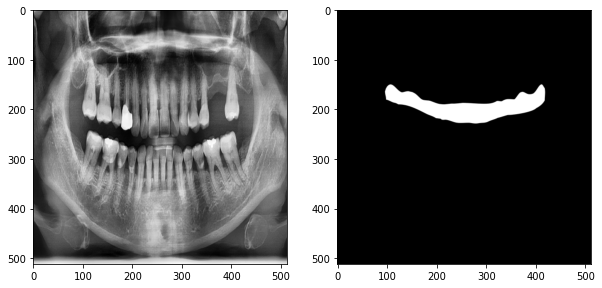

In [5]:
# plot the teeth and mask
index = 13
_, aux = plt.subplots(1, 2, figsize=(10, 5))
teeth, mask = original_dataset[index], pbl_dataset[index]
aux[0].imshow(teeth, cmap='gray')
aux[1].imshow(mask, cmap='gray')

In [6]:
(X_train, y_train), (X_test, y_test) = split_train_test(original_dataset, pbl_dataset, 80)

In [7]:
pbl_model = tooth_model(input_shape = (512, 512, 1))
pbl_model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Your choice batch and epoch 
history = pbl_model.fit(X_train,y_train,validation_split = 0.2,batch_size=4,epochs=35,verbose=1)
pbl_model.save('./model.h5')
# pbl_model.summary()

Epoch 1/35
7/7 [==============================] - 16s 384ms/step - loss: 0.3766 - accuracy: 0.8227 - val_loss: 0.6137 - val_accuracy: 0.9241
Epoch 2/35
7/7 [==============================] - 2s 315ms/step - loss: 0.1700 - accuracy: 0.9544 - val_loss: 0.2648 - val_accuracy: 0.9241
Epoch 3/35
7/7 [==============================] - 2s 313ms/step - loss: 0.1306 - accuracy: 0.9544 - val_loss: 0.3075 - val_accuracy: 0.9241
Epoch 4/35
7/7 [==============================] - 2s 314ms/step - loss: 0.1026 - accuracy: 0.9543 - val_loss: 0.3913 - val_accuracy: 0.9241
Epoch 5/35
7/7 [==============================] - 2s 315ms/step - loss: 0.0852 - accuracy: 0.9553 - val_loss: 0.4895 - val_accuracy: 0.9241
Epoch 6/35
7/7 [==============================] - 2s 313ms/step - loss: 0.0786 - accuracy: 0.9654 - val_loss: 0.5181 - val_accuracy: 0.9241
Epoch 7/35
7/7 [==============================] - 2s 316ms/step - loss: 0.0706 - accuracy: 0.9641 - val_loss: 0.5070 - val_accuracy: 0.9241
Epoch 8/35
7/7 [===

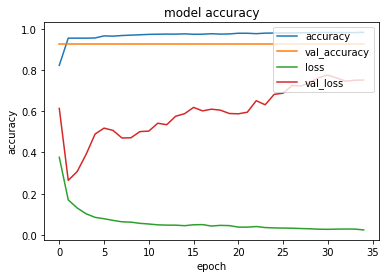

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='upper right')
plt.savefig('./model_perfomance.png', facecolor='white', dpi=1000)
plt.show()

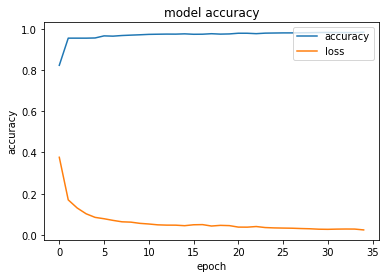

In [9]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper right')
plt.savefig('./model_perfomance_1.png', facecolor='white', dpi=1000)
plt.show()

In [10]:
predict = pbl_model.predict(X_test)

In [11]:
predict.shape

(9, 512, 512, 1)

In [12]:
# plt.imshow(predict[6], cmap='gray')

In [13]:
# plt.imshow(X_train[6], cmap='gray')

In [14]:
# overlap PBl and individual teeth
index = 13
original_dataset = load_dataset(TEETH_DATASET,rgb= True, normalize=False)
pbl_dataset = load_dataset(TEETH_PBL,rgb= True,  normalize=False)
numbering_dataset = load_dataset(TEETH_NUMBER, rgb= True, normalize=False)
original_image = original_dataset[index]
original_image = np.reshape(np.stack((original_image,)*3, axis=-1),(512,512,3))
pbl_image = pbl_dataset[index]
numbering_image = numbering_dataset[index]

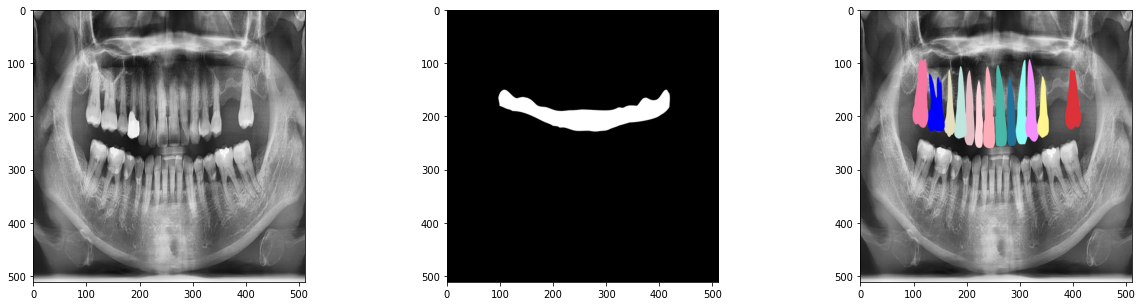

In [15]:
_, aux = plt.subplots(1, 3, figsize=(21, 5))
aux[0].imshow(original_image)
aux[1].imshow(pbl_image)
aux[2].imshow(numbering_image)

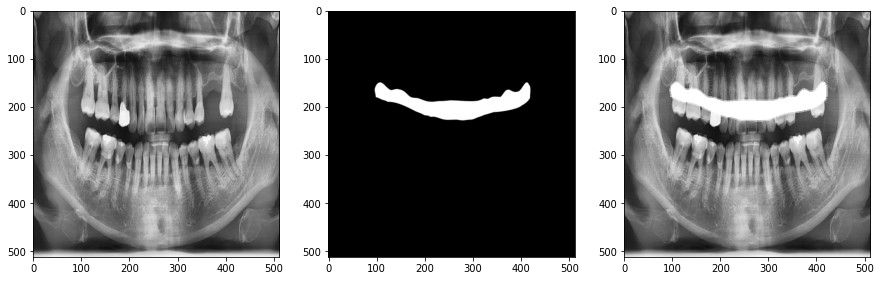

In [23]:
temp_pbl_image = pbl_image.copy()
original_pbl_image = original_image.copy()
for i_index, i in enumerate(temp_pbl_image): #512
    for j_index,j in enumerate(i): #512
        for k_index, k in enumerate(j): #1
            if k > 0.5:
                original_pbl_image[i_index][j_index][k_index] = 255
_, aux = plt.subplots(1, 3, figsize=(15, 5))
aux[0].imshow(original_image, cmap='gray')
aux[1].imshow(pbl_image, cmap='gray')
aux[2].imshow(original_pbl_image, cmap='gray')

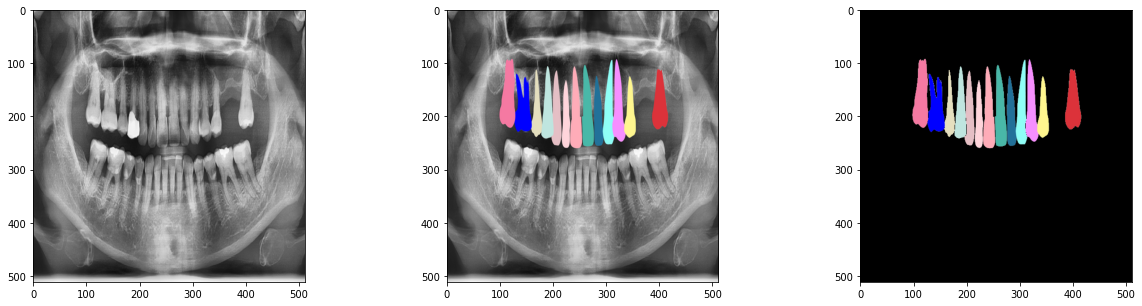

In [24]:
temp_pbl_image = pbl_image.copy()
temp_original_image = original_image.copy()
temp_numbering_image = numbering_image.copy()

numbering_mask = np.full((512,512,3), 255)
for i_index, i in enumerate(temp_numbering_image): #512
    for j_index, j in enumerate(i): #512
        if not ((j.sum()/3 > (j[0] - 12)) and (j.sum()/3 < (j[0] + 12))) : 
            numbering_mask[i_index][j_index] = temp_numbering_image[i_index][j_index]
        else:
            numbering_mask[i_index][j_index] = [0,0,0]
_, aux = plt.subplots(1, 3, figsize=(21, 5))
aux[0].imshow(temp_original_image)
aux[1].imshow(temp_numbering_image)
aux[2].imshow(numbering_mask)

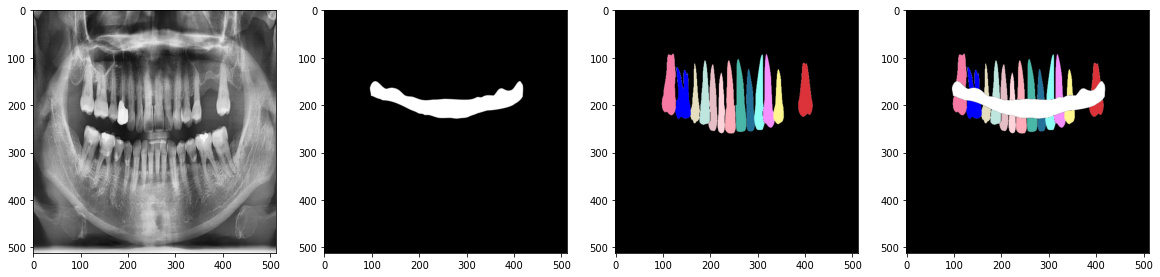

In [25]:
temp_pbl_image = pbl_image.copy()
temp_original_image = original_image.copy()
temp_numbering_image = numbering_image.copy()
original_pbl_numbering = np.full((512,512,3), 255)
for i_index, i in enumerate(numbering_mask): #512
    for j_index,j in enumerate(i): #512
        if j.sum() != 0:
            original_pbl_numbering[i_index][j_index] = temp_numbering_image[i_index][j_index]
        else:
            original_pbl_numbering[i_index][j_index] = [0,0,0]

for i_index, i in enumerate(temp_pbl_image): #512
    for j_index,j in enumerate(i): #512
        if j.sum() > 250:
            original_pbl_numbering[i_index][j_index] = temp_pbl_image[i_index][j_index]

_, aux = plt.subplots(1, 4, figsize=(20, 5))
aux[0].imshow(temp_original_image)
aux[1].imshow(temp_pbl_image)
aux[2].imshow(numbering_mask)
aux[3].imshow(original_pbl_numbering)

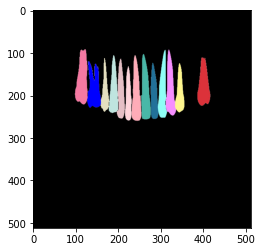

In [26]:
plt.imshow(numbering_mask)

In [2]:
# Load Yolo model files
yolo_weight = "./yolo/yolov3.weights"
yolo_config = "./yolo/yolov3.cfg"
coco_labels = "./yolo/coco.names"
net = cv2.dnn.readNet(yolo_weight, yolo_config)
 
# Load coco object names file
classes = []
with open(coco_labels, "r") as f:
    classes = [line.strip() for line in f.readlines()]

In [3]:
resize_teeth_numbering = cv2.imread('./cat.jpg')

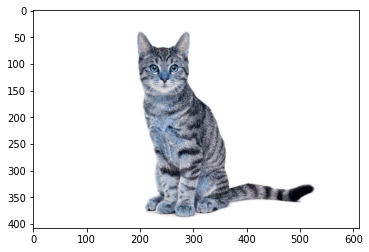

In [4]:
plt.imshow(resize_teeth_numbering)

In [6]:
# # Defining desired shape
fWidth = 320
fHeight = 320
 
# Resize image in opencv
resize_teeth_numbering =  cv2.resize(resize_teeth_numbering, (fWidth, fHeight))
 
height, width, channels = resize_teeth_numbering.shape

# # Convert image to Blob
blob = cv2.dnn.blobFromImage(resize_teeth_numbering, 1/255, (fWidth, fHeight), (0, 0, 0), True, crop=False)
# # Set input for YOLO object detection
net.setInput(blob)

# # Find names of all layers
layer_names = net.getLayerNames()
# print(layer_names)
# # Find names of three output layers
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# print(output_layers)

# # Send blob data to forward pass
outs = net.forward(output_layers)
print(outs[0].shape)
print(outs[1].shape)
print(outs[2].shape)

(300, 85)
(1200, 85)
(4800, 85)


In [7]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [8]:
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        # Extract score value
        scores = detection[5:]
        # Object id
        class_id = np.argmax(scores)
        # Confidence score for each object ID
        confidence = scores[class_id]
        # if confidence > 0.5 and class_id == 0:
        if confidence > 0.5:
            # Extract values to draw bounding box
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
 
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

In [9]:
# Draw bounding box with text for each object
font = cv2.FONT_HERSHEY_DUPLEX
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence_label = int(confidences[i] * 100)
        color = colors[i]
        cv2.rectangle(resize_teeth_numbering, (x, y), (x + w, y + h), color, 2)
        cv2.putText(resize_teeth_numbering, f'{label, confidence_label}', (x-25, y + 75), font, 1, color, 2)
 
cv2.imshow("Image", resize_teeth_numbering)
cv2.waitKey(0)
cv2.destroyAllWindows()

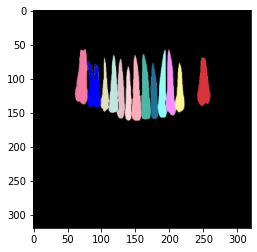

In [86]:
plt.imshow(resize_teeth_numbering)

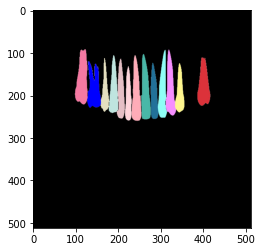

In [135]:
temp_resize_teeth_numbering = resize_teeth_numbering.copy()
# original_pbl_image = original_image.copy()
count=0
for i_index, i in enumerate(resize_teeth_numbering): #512
    for j_index,j in enumerate(i): #512
        temp_resize_teeth_numbering[i][j] = [255,255,255]
#         if j.sum() == 0:
#             temp_resize_teeth_numbering[i][j][0] = 255.0
#             temp_resize_teeth_numbering[i][j][1] = 255.0
#             temp_resize_teeth_numbering[i][j][2] = 255.0
#         if count > 200
#             break
    count += 1
    if count > 200:
        break
#             print(j)
#             break
plt.imshow(temp_resize_teeth_numbering)

In [152]:
resize_teeth_numbering = numbering_mask.copy()
resize_teeth_numbering = resize_teeth_numbering.astype(np.uint8)

In [147]:
w, h, c = resize_teeth_numbering.shape

In [148]:
if cv2.countNonZero(resize_teeth_numbering) > ((w*h)//2):
    pass
else:
    print('a')

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\core\src\count_non_zero.dispatch.cpp:128: error: (-215:Assertion failed) cn == 1 in function 'cv::countNonZero'


In [153]:
resize_teeth_numbering = cv2.bitwise_not(resize_teeth_numbering)

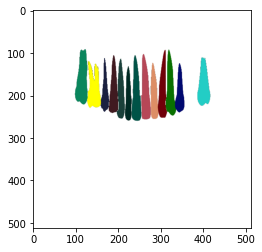

In [154]:
plt.imshow(bw)

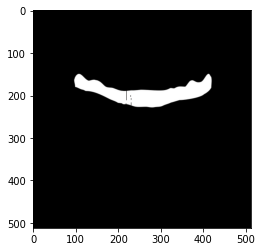

In [19]:
temp_pbl_image = pbl_image.copy()
temp_original_image = original_image.copy()
temp_numbering_image = numbering_image.copy()
for i_index, i in enumerate(numbering_mask): #512
    for j_index,j in enumerate(i): #512
        if j.sum() > 700:
            temp_pbl_image[i_index][j_index][0] = numbering_mask[i_index][j_index][0] /255
            temp_pbl_image[i_index][j_index][1] = numbering_mask[i_index][j_index][1] /255
            temp_pbl_image[i_index][j_index][2] = numbering_mask[i_index][j_index][2] /255
plt.imshow(temp_pbl_image)

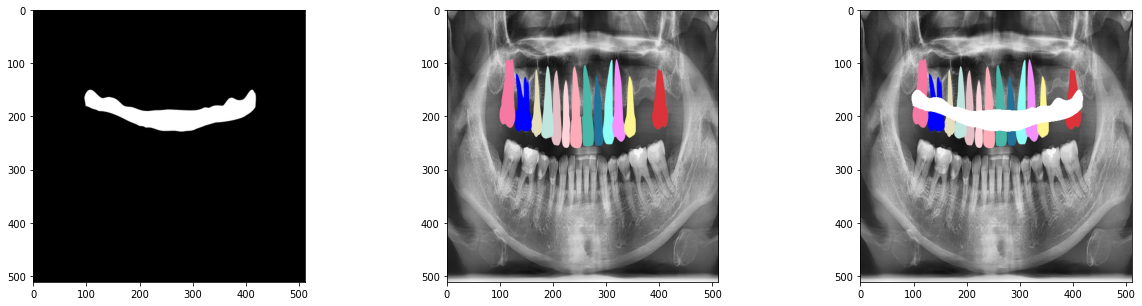

In [20]:
temp_pbl_image = pbl_image.copy()
temp_original_image = original_image.copy()
temp_numbering_image = numbering_image.copy()

for i_index, i in enumerate(temp_pbl_image): #512
    for j_index,j in enumerate(i): #512
        for k_index, k in enumerate(j): #1
            if k > 100:
                temp_numbering_image[i_index][j_index][k_index] = 255

_, aux = plt.subplots(1, 3, figsize=(21, 5))
aux[0].imshow(temp_pbl_image)
aux[1].imshow(numbering_image)
aux[2].imshow(temp_numbering_image)

In [22]:
plb_3_channel = np.reshape(np.stack((pbl_image.copy(),)*3, axis=-1),(512,512,3))
temp_temp_numbering_image = temp_numbering_image.copy()
for i_index, i in enumerate(plb_3_channel): #512
    for j_index,j in enumerate(i): #512
        if j.sum() > 0.2:
#             print(temp_temp_numbering_image[i_index][j_index][0])
            temp_temp_numbering_image[i_index][j_index][0] = plb_3_channel[i_index][j_index][0] * 255
            temp_temp_numbering_image[i_index][j_index][1] = plb_3_channel[i_index][j_index][1] * 255
            temp_temp_numbering_image[i_index][j_index][2] = plb_3_channel[i_index][j_index][2] * 255
plt.imshow(temp_temp_numbering_image)

ValueError: cannot reshape array of size 2359296 into shape (512,512,3)

SyntaxError: invalid syntax (<ipython-input-135-c9b06c200cb0>, line 8)

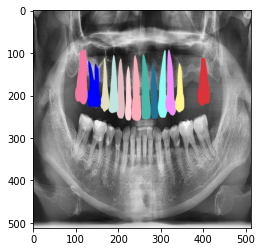

In [100]:
plt.imshow(temp_numbering_image)

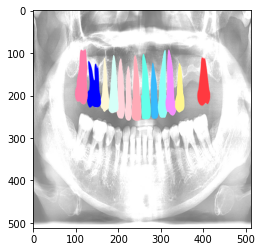

In [772]:
frame = increase_brightness(temp_numbering_image, value=100)
plt.imshow(frame)

In [766]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

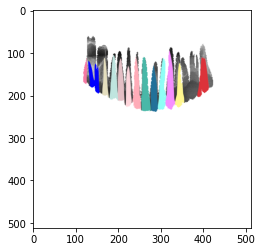

In [87]:
def get_teeth_numbering_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0, 0, 5), (255, 5, 255))
    nzmask = cv2.inRange(hsv, (0, 0, 5), (255, 255, 255))
    nzmask = cv2.erode(nzmask, np.ones((3,3)))
    mask = mask & nzmask
    new_img = img.copy()
    new_img[np.where(mask)] = 255
    return new_img

plt.imshow(get_teeth_numbering_mask(numbering_dataset[3]))

In [ ]:
#         bottom_threshold = 5
#         top_threshold = 250
#         print(temp_original_image[i_index][j_index][0])
#         print(j[0])
#         different_red = abs(temp_original_image[i_index][j_index][0] - j[0])
#         different_green = abs(temp_original_image[i_index][j_index][1] - j[1])
#         different_blue = abs(temp_original_image[i_index][j_index][2] - j[2])
#         total_different = different_red + different_green + different_blue
#         if (total_different < bottom_threshold) or ((different_red == different_green == different_blue) and (total_different >top_threshold)):
#             print(different_red)
#             print(different_green)
#             print(different_blue)
#             print(f"Total => {total_different}")
#         if (total_different < bottom_threshold) or (total_different > top_threshold):
#             temp_numbering_image[i_index][j_index][0] = 0
#             temp_numbering_image[i_index][j_index][1] = 0
#             temp_numbering_image[i_index][j_index][2] = 0
# plt.imshow(temp_numbering_image)

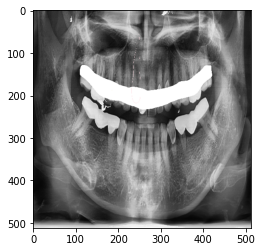

In [620]:
plb_3_channel = np.reshape(np.stack((temp_pbl_image.copy(),)*3, axis=-1),(512,512,3))
temp_temp_numbering_image = temp_numbering_image.copy()
for i_index, i in enumerate(temp_temp_numbering_image): #512
    for j_index,j in enumerate(i): #512
        if j.sum() > 700:
            plb_3_channel[i_index][j_index][0] = temp_temp_numbering_image[i_index][j_index][0] /255
            plb_3_channel[i_index][j_index][1] = temp_temp_numbering_image[i_index][j_index][1] /255
            plb_3_channel[i_index][j_index][2] = temp_temp_numbering_image[i_index][j_index][2] /255
plt.imshow(plb_3_channel)

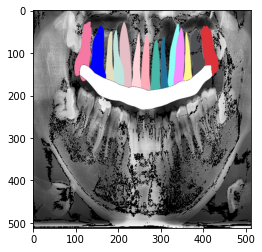

In [618]:
plb_3_channel = np.reshape(np.stack((pbl_image.copy(),)*3, axis=-1),(512,512,3))
temp_temp_numbering_image = temp_numbering_image.copy()
for i_index, i in enumerate(plb_3_channel): #512
    for j_index,j in enumerate(i): #512
        if j.sum() > 0.2:
#             print(temp_temp_numbering_image[i_index][j_index][0])
            temp_temp_numbering_image[i_index][j_index][0] = plb_3_channel[i_index][j_index][0] * 255
            temp_temp_numbering_image[i_index][j_index][1] = plb_3_channel[i_index][j_index][1] * 255
            temp_temp_numbering_image[i_index][j_index][2] = plb_3_channel[i_index][j_index][2] * 255
plt.imshow(temp_temp_numbering_image)

In [430]:
_, aux = plt.subplots(1, 3, figsize=(15, 5))
aux[0].imshow(original_image, cmap='gray')
aux[1].imshow(pbl_image, cmap='gray')
aux[2].imshow(temp_image, cmap='gray')
plt.imshow(cv2.cvtColor(temp_numbering_image, cv2.COLOR_BGR2RGB))

(512, 512, 3)

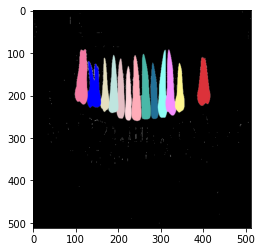

In [581]:
plt.imshow(temp_temp_numbering_image)

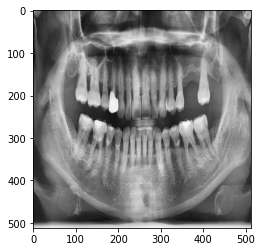

In [571]:
plt.imshow(temp_original_image)

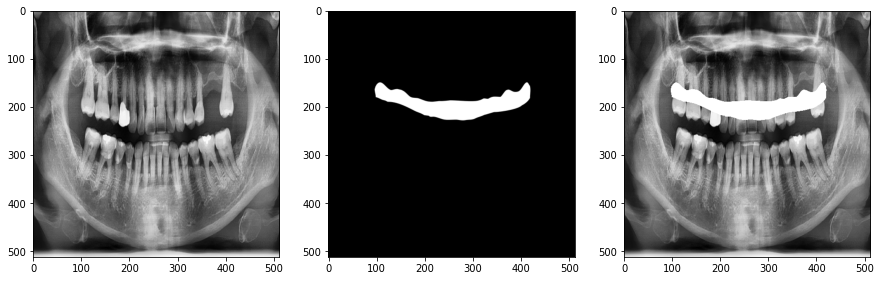

In [483]:
temp_image = original_image.copy()
for i_index, i in enumerate(pbl_image): #512
    for j_index,j in enumerate(i): #512
        for k_index, k in enumerate(j): #1
            if k > 0.5:
                temp_image[i_index][j_index][k_index] = 1
                
_, aux = plt.subplots(1, 3, figsize=(15, 5))
aux[0].imshow(original_image, cmap='gray')
aux[1].imshow(pbl_image, cmap='gray')
aux[2].imshow(temp_image, cmap='gray')

In [ ]:
for i_index, i in enumerate(pbl_image): #512
    for j_index,j in enumerate(i): #512
        for k_index, k in enumerate(j): #1
            if k == 1:
                print(k)

In [10]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...


In [11]:
!pip install -U -r yolov5/requirements.txt

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Program Files\\Python\\Lib\\site-packages\\~il\\_imaging.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\program files\python\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: requests
    Found existing installation: requests 2.21.0
    Uninstalling requests-2.21.0:
      Successfully uninstalled requests-2.21.0
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.1.0
    Uninstalling Pillow-8.1.0:
      Successfully uninstalled Pillow-8.1.0


In [4]:
import tensorflow as tf
import keras

In [3]:
model = keras.models.load_model('./result/unet/unet_model.h5')

ValueError: Unknown layer: Functional

In [6]:
!python3 ./main.py --pbl

wandb: Currently logged in as: saosokleng (use `wandb login --relogin` to force relogin)
Using TensorFlow backend.
==> start unet traning
2022-01-17 09:26:33.719374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 09:26:33.719706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 09:26:33.726668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 09:26:33.726980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returni

In [14]:
!python3 ./main.py --yolo

wandb: Currently logged in as: saosokleng (use `wandb login --relogin` to force relogin)
Using TensorFlow backend.
==> start yolo traning
aa
train: weights=./yolov5s.pt, cfg=, data=custom-coco.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, batch=16
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 39567ae torch 1.7.1+cu110 CUDA:0 (Tesla V100S-PCIE-32GB, 32511MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0,

In [7]:
# Load required modules
%matplotlib inline
import math, os, cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,Conv2DTranspose,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from PIL import Image
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
from yolov5.train import run as run_train
from yolov5.detect import run as run_detect
from  matplotlib import pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

AttributeError: module 'keras.utils.layer_utils' has no attribute 'cached_per_instance'